In [1]:
import numpy as np
from deap import base, creator, tools, benchmarks
import deap.cma as cma
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
from scipy.integrate import odeint
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from Modules.Helper import Helper
from Modules.Solvers import Solvers
from Modules.Plotters import Plotters
import pandas as pd
from Modules.Equation import Equation

In [2]:
labels = ['A', 'B', 'C', 'D', 'E']
df, max_data = Helper.load_data(filename='Data/GRN5_DATA.txt', labels=labels)
initial_conditions = np.array([df[label].iloc[0] for label in labels])
t_span = (df['t'].iloc[0], df['t'].iloc[-1])
t_eval = np.array(df['t'])
original = np.array(df[labels]).T

In [3]:
# Definindo os limites para os coeficientes
bounds = {
    'tau': (0.1, 10.0),
    'k': (0.1, 5.0),
    'n': (0.1, 5.0),
    'strategy': (0.1, 10)
}

IND_SIZE = 19

In [4]:
class Coefficient:
    def __init__(self, bounds_val, bounds_strg):
        self.val = random.uniform(*bounds_val)
        self.strg = random.uniform(*bounds_strg)
        self.bounds_strg = bounds_strg
        self.bounds_val = bounds_val
        
    def aux_mutate_logNormal(self, t0_n, t, verify_max_strg):
        self.strg *=  math.exp(t0_n + t * random.gauss(0, 1))
        self.val *= self.strg * random.gauss(0, 1)
        
        if verify_max_strg:
            self.strg = min(self.strg, self.bounds_strg[1])
          
    def mutate_logNormal(self, t0_n, t):
        val = self.val
        strg = self.strg
        self.aux_mutate_logNormal(t0_n, t, True)
        
        while self.val < self.bounds_val[0] or self.val > self.bounds_val[1]:
            self.val = val
            self.strg = strg
            self.aux_mutate_logNormal(t0_n, t, False)

    
    def __repr__(self):
        return f"val={self.val}, stratergy={self.strg}"

class CMACoefficient:
    def __init__(self, val, bounds_val):
        self.bounds_val = bounds_val
        self.val = self.limit_val(val)
    
    def limit_val(self, val):
        return max(self.bounds_val[0], min(val, self.bounds_val[1]))
    
    def __repr__(self):
        return f"val={self.val}"

class Individual:
    def __init__(self):
        self.coeffs = {
            'A': {
                'E': {'n': None, 'k': None, '-': True},
                'tau': None
            },
            'B': {
                'A': {'n': None, 'k': None, '-': False},
                'tau': None
            },
            'C': {
                'B': {'n': None, 'k': None, '-': False},
                'tau': None,
            },
            'D': {
                'C': {'n': None, 'k': None, '-': False},
                'tau': None,
            },
            'E': {
                'D': {'n': None, 'k': None, '-': False},
                'B': {'n': None, 'k': None, '-': False},
                'E': {'n': None, 'k': None, '-': False},
                'tau': None,
            }
        }
        self.strategy = []
        self.ind_size = IND_SIZE
        self.fitness = np.inf
        # self.fitness = random.uniform(0, 1)
    
    @staticmethod
    def list_to_ind(list_ind):
        i = 0
        ind = Individual()
        for key, label in ind.coeffs.items():
            label['tau'] = CMACoefficient(list_ind[i], bounds['tau'])
            i += 1
            for key, coeffs in label.items():
                if key != 'tau':
                    coeffs['n'] = CMACoefficient(list_ind[i], bounds['n'])
                    coeffs['k'] = CMACoefficient(list_ind[i+1], bounds['k'])
                    i += 2
        return ind
    
    def ind_to_list(self):
        ind_list = []
        for key, label in self.coeffs.items():
            ind_list.append(label['tau'].val)
            for key, coeffs in label.items():
                if key != 'tau':
                    ind_list.append(coeffs['n'].val)
                    ind_list.append(coeffs['k'].val)
        return ind_list
    
    @staticmethod
    def apply_bounds(population):
        for ind in population:
            list_ind = Individual.list_to_ind(ind)
            ind[:] = Individual.ind_to_list(list_ind)
    
    @staticmethod    
    def cma_evaluate(list_ind):
        ind = Individual.list_to_ind(list_ind)
        ind.calc_fitness()
        return ind.fitness,
        # return ind
        
    
    def mutate_logNormal(self, c, mut_prob):
        t = c / math.sqrt(2. * math.sqrt(self.ind_size))
        t0 = c / math.sqrt(2. * self.ind_size)
        n = random.gauss(0, 1)
        t0_n = t0 * n
        
        for key, label in self.coeffs.items():
            if random.random() < mut_prob:
                label['tau'].mutate_logNormal(t0_n, t)
            
            for key, coeffs in label.items():
                if key != 'tau':
                    if random.random() < mut_prob:
                        coeffs['n'].mutate_logNormal(t0_n, t)
                        
                    if random.random() < mut_prob:
                        coeffs['k'].mutate_logNormal(t0_n, t)
                        
        self.fitness = np.inf
    
    def calc_fitness(self, method='RK45'):
        try:
            equation = Equation(self.numerical_coeffs, labels)
            y = solve_ivp(self.system, t_span, initial_conditions, method=method, t_eval=t_eval, args=(equation, )).y
            self.fitness = self.abs_error(original, y)
        except:
            print("Overflow")
            self.fitness = np.inf
       
    @staticmethod
    def system(t, y, equation):
        vals = [Solvers.norm_hardcoded(val, max_data[label]) for val, label in zip(y, labels)]
        N_A, N_B, N_C, N_D, N_E = vals
        
        dA = equation.full_eq(vals, 'A', 'E')
        dB = equation.full_eq(vals, 'B', 'A')
        dC = equation.full_eq(vals, 'C', 'B')
        dD = equation.full_eq(vals, 'D', 'C')
        dE = equation.complex_eqs(vals, 'E', [['+B', '+D'], ['+D', '+E']])

        return [dA, dB, dC, dD, dE]
    
    @staticmethod
    def abs_error(original, pred):
        return sum(sum(abs(original-pred)))
    
    @staticmethod
    def squared_error(original, pred):
        return sum(sum( (original-pred)**2 ))**(1/2)
            
    @staticmethod
    def initialize_ind(bounds):
        ind = Individual()
        for key, label in ind.coeffs.items():
            label['tau'] = Coefficient(bounds['tau'], bounds['strategy'])
            for key, coeffs in label.items():
                if key != 'tau':
                    coeffs['n'] = Coefficient(bounds['n'], bounds['strategy'])
                    coeffs['k'] = Coefficient(bounds['k'], bounds['strategy'])
                    
        ind.calc_fitness()
        return ind
    
    @property
    def numerical_coeffs(self,):
        
        numerical_coeffs = copy.deepcopy(self.coeffs)
        for key, label in numerical_coeffs.items():
            label['tau'] = label['tau'].val
            for key, coeffs in label.items():
                if key != 'tau':
                    coeffs['n'] = int(coeffs['n'].val)
                    coeffs['k'] = coeffs['k'].val
                    
        return numerical_coeffs
    
    
    def plot(self, method='RK45', comparison=True):
        methods = [method]
        results = {}
        equation = Equation(self.numerical_coeffs, labels)
        results[method] = solve_ivp(self.system, t_span, initial_conditions, method=method, t_eval=t_eval, args=(equation, )).y
        Plotters.plot_methods(results=results,t=t_eval, methods=methods, labels=labels)
        if comparison:
            Plotters.plot_comparison(results=results, t=t_eval, df=df, methods=methods, labels=labels)
        
        
    def __repr__(self):
        coeffs_repr = {k: v for k, v in self.coeffs.items()}
        strategy_repr = self.strategy
        return f"Individual(fitness={self.fitness}, coeffs={coeffs_repr}, strategy={strategy_repr}, ind_size={self.ind_size})"

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", Individual.cma_evaluate)

In [6]:
strategy = cma.Strategy(centroid=[5]*IND_SIZE, sigma=5, lambda_=20*IND_SIZE)

toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)


In [7]:
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

Generation 0: {'avg': 179.346509390865, 'std': 18.948598169833172, 'min': 126.81597380609949, 'max': 215.79812345253055}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=5.0, '-': True}, 'tau': val=4.8029092223679}, 'B': {'A': {'n': val=0.1, 'k': val=3.6359646019296648, '-': False}, 'tau': val=5.259971020590436}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=6.381340890148014}, 'D': {'C': {'n': val=0.41489620008507, 'k': val=0.9365394031380756, '-': False}, 'tau': val=2.2218298421940412}, 'E': {'D': {'n': val=5.0, 'k': val=5.0, '-': False}, 'B': {'n': val=3.1472863702637697, 'k': val=2.8273910308351664, '-': False}, 'E': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=9.52545052599192}}


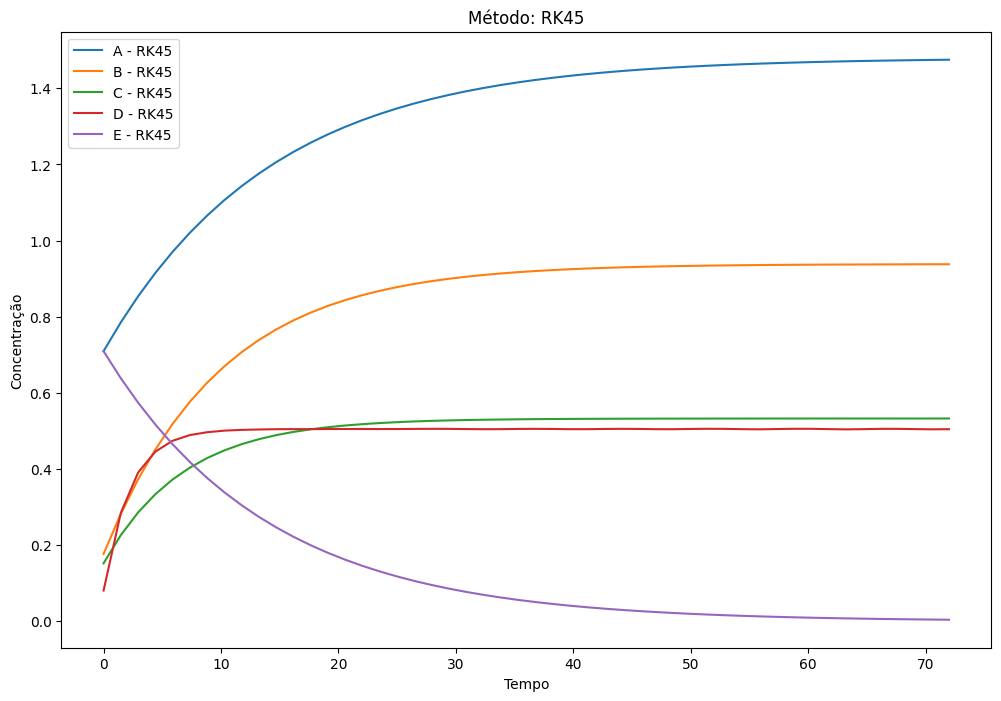

Generation 1: {'avg': 157.9996578403413, 'std': 25.511756280606306, 'min': 103.18817215786557, 'max': 216.38236668360307}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=0.1}, 'C': {'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.3396976404405905, '-': False}, 'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=0.1}}


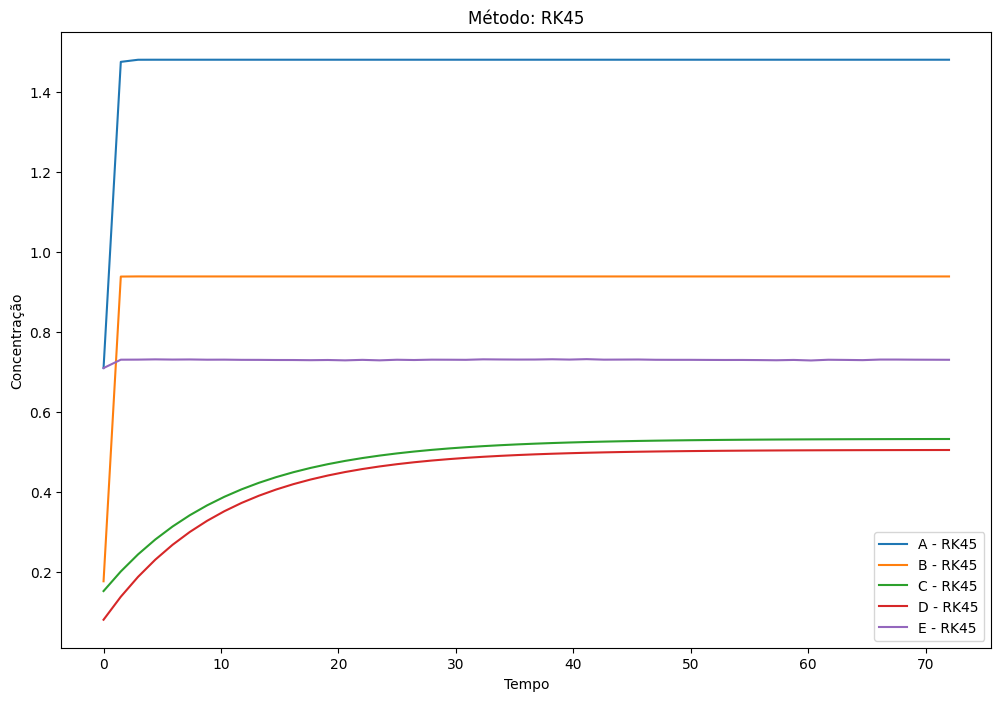

Generation 2: {'avg': 143.62014347754854, 'std': 24.71277173680135, 'min': 102.75294608343123, 'max': 221.87857070055455}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=4.332721101916771, '-': False}, 'tau': val=2.668422363422451}, 'C': {'B': {'n': val=0.1, 'k': val=4.656658358698928, '-': False}, 'tau': val=10.0}, 'D': {'C': {'n': val=0.1, 'k': val=4.991354881898736, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=4.140042971445827, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=1.0349644575765433, '-': False}, 'E': {'n': val=5.0, 'k': val=5.0, '-': False}, 'tau': val=10.0}}


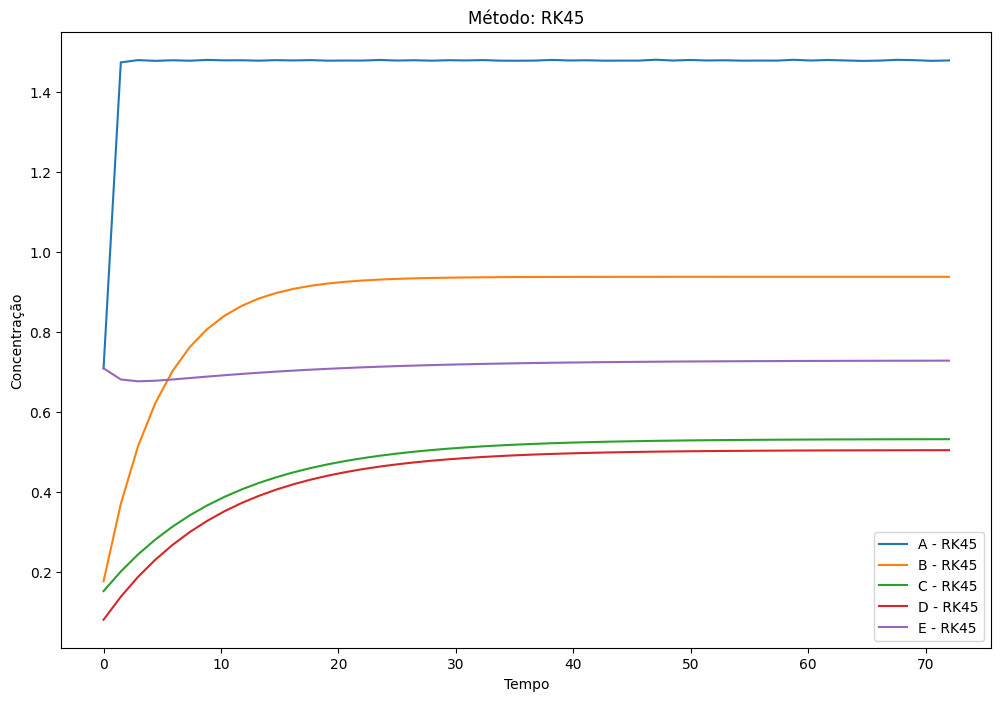

Generation 3: {'avg': 133.0477545939403, 'std': 24.469047998293014, 'min': 101.70488557121831, 'max': 215.14064297786373}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=1.7778031750643322}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=5.107880468158967}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}}


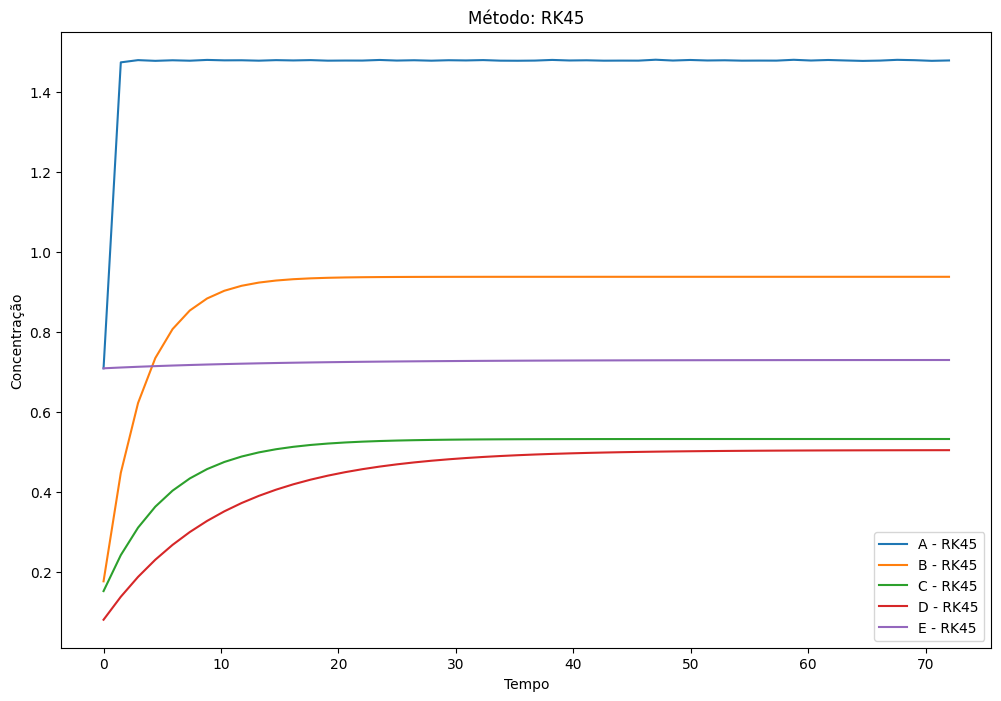

Generation 4: {'avg': 126.10729361085775, 'std': 23.138386419458115, 'min': 102.20112990533394, 'max': 211.53612104912003}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=1.7778031750643322}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=5.107880468158967}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}}


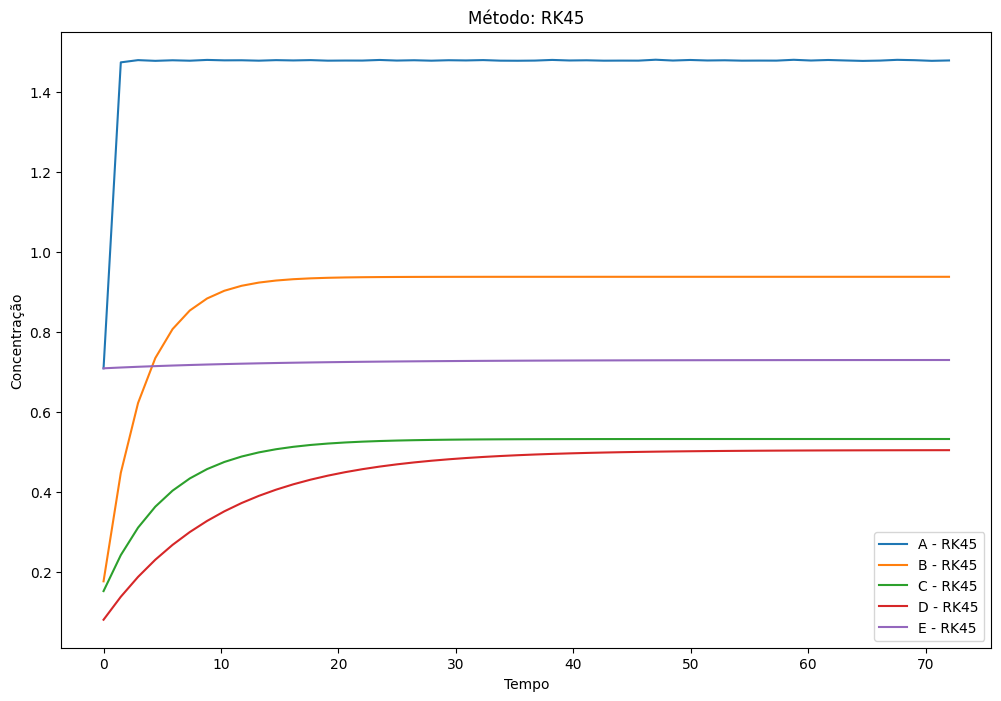

Generation 5: {'avg': 121.90124825919034, 'std': 22.6287820119556, 'min': 101.80337915994109, 'max': 215.87996445987278}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=1.7778031750643322}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=5.107880468158967}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}}


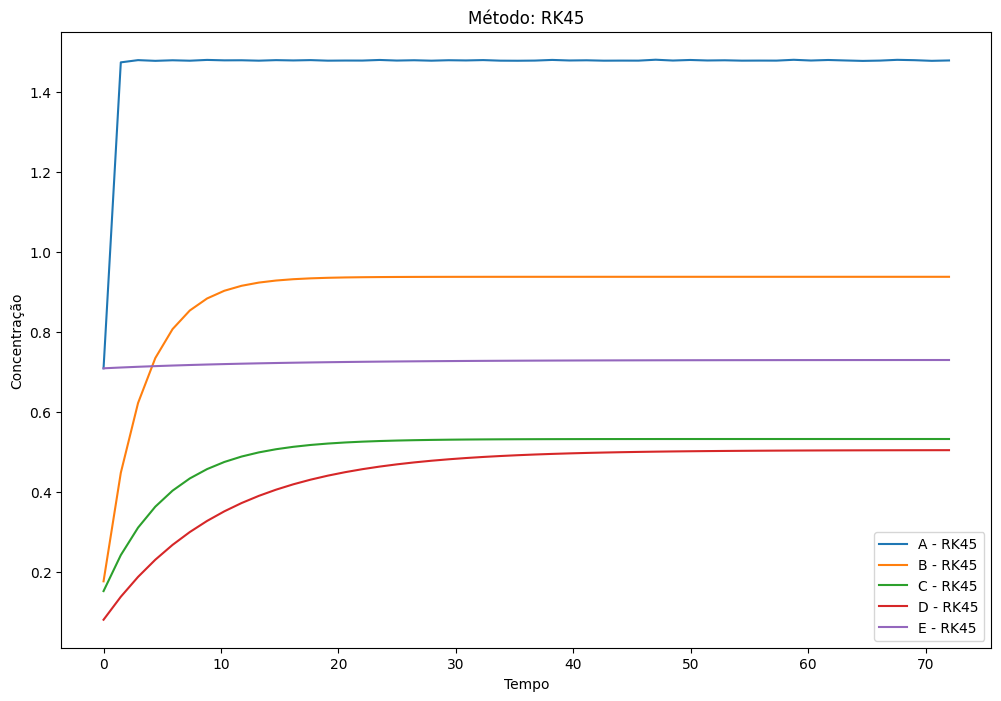

Generation 6: {'avg': 115.73307128967281, 'std': 19.371388272584145, 'min': 102.02212318177591, 'max': 206.35648600114595}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=1.7778031750643322}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=5.107880468158967}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}}


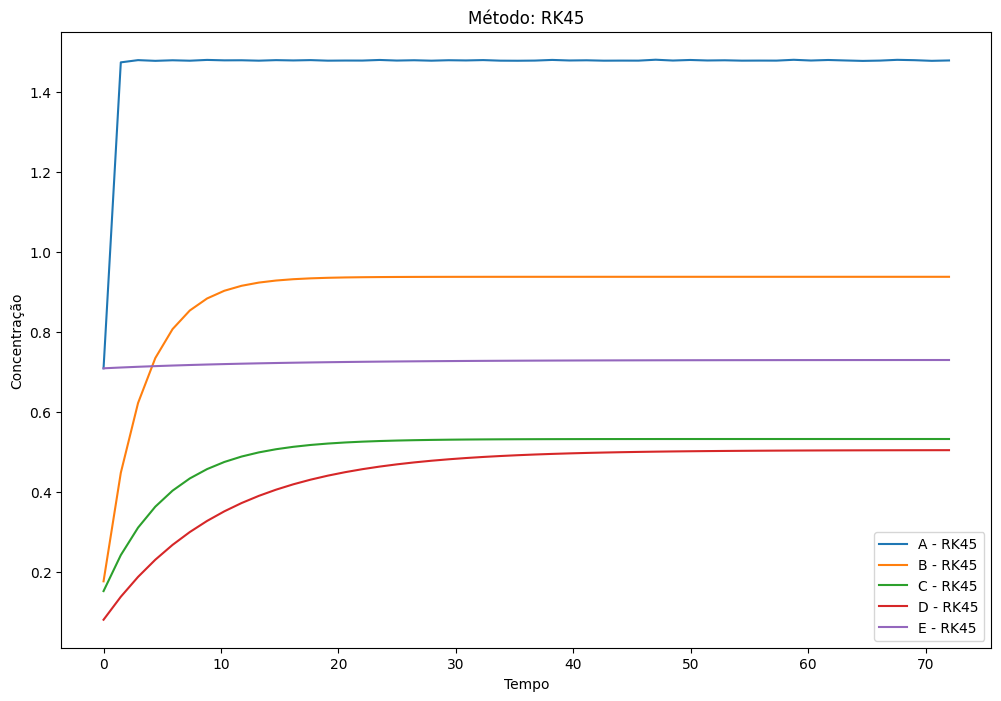

Generation 7: {'avg': 116.39962072609373, 'std': 21.09018693480945, 'min': 102.22518158338073, 'max': 211.2061434465003}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=1.7778031750643322}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=5.107880468158967}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}}


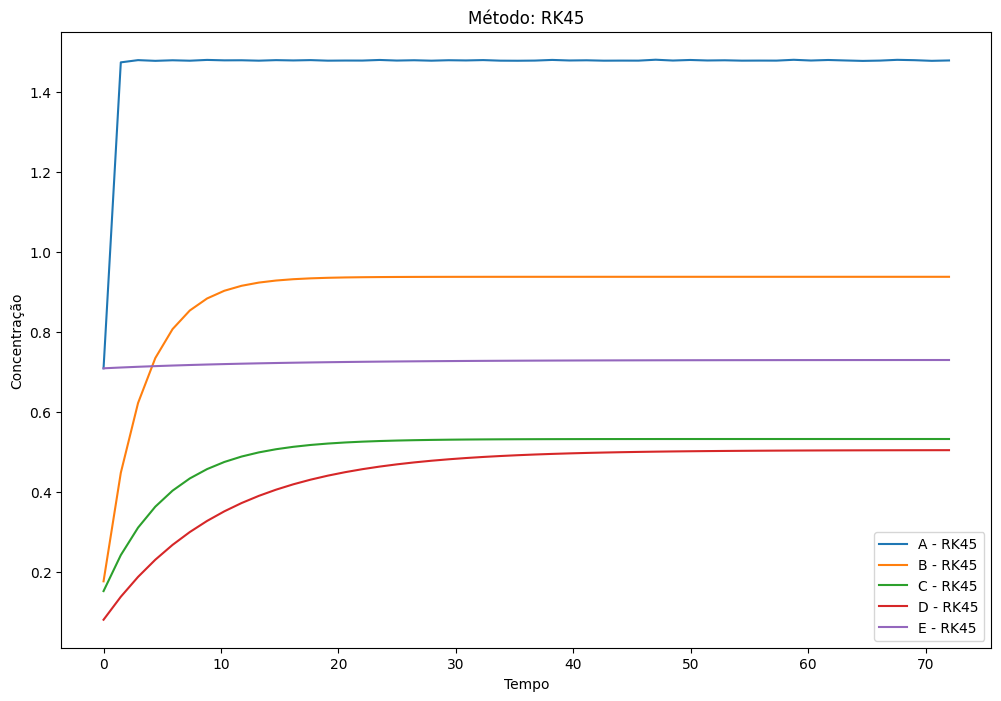

Generation 8: {'avg': 114.06442176191591, 'std': 19.22892254528761, 'min': 102.05162525383064, 'max': 211.12116067558355}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=1.7778031750643322}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=5.107880468158967}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}}


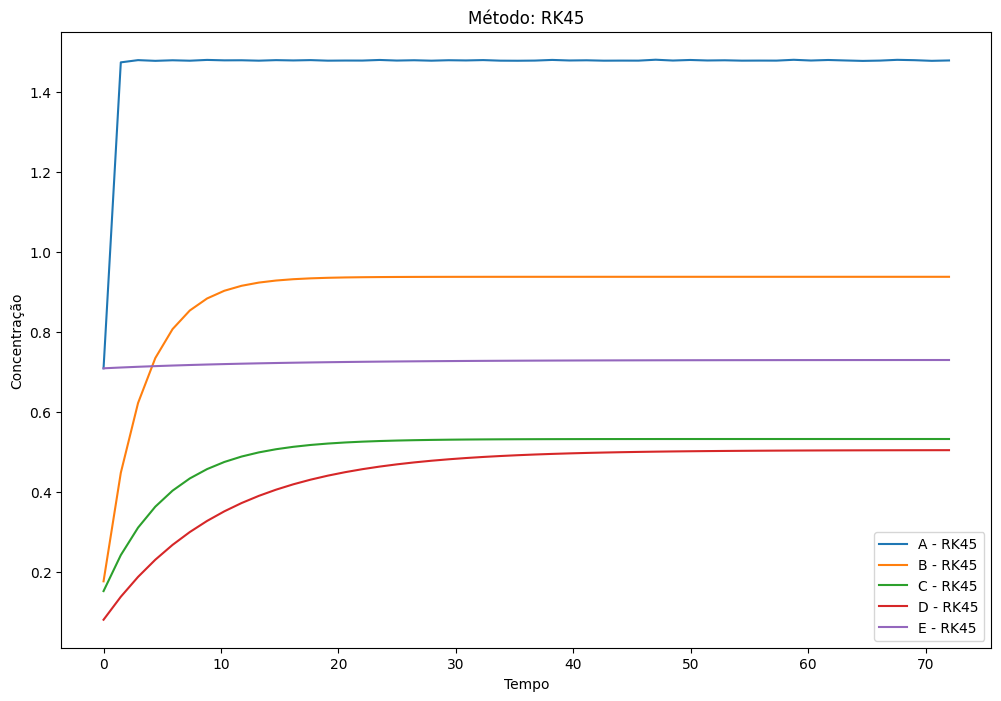

Generation 9: {'avg': 112.80729727764238, 'std': 19.7535647527946, 'min': 102.34743608326761, 'max': 211.13004776036027}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=1.7778031750643322}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=5.107880468158967}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}}


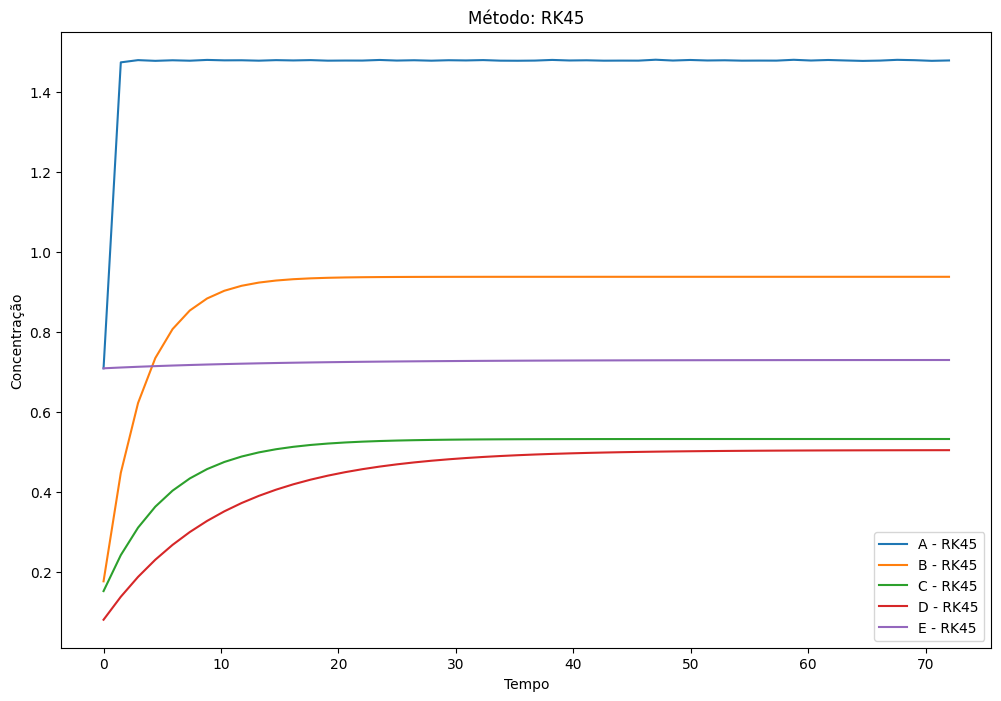

Overflow


C:\Users\anabi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Generation 10: {'avg': inf, 'std': nan, 'min': 102.1958951043653, 'max': inf}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=1.7778031750643322}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=5.107880468158967}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}}


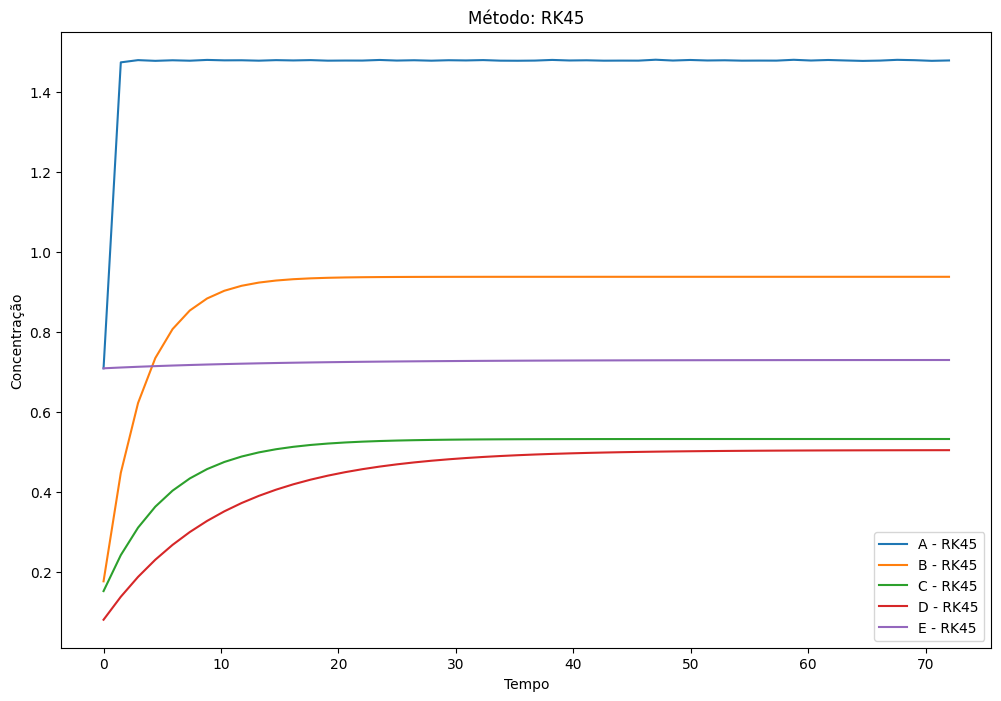

Generation 11: {'avg': 111.264555350624, 'std': 18.530201536452545, 'min': 102.29447722089571, 'max': 200.20160087576784}
best ind coeffs: {'A': {'E': {'n': val=0.1, 'k': val=0.1, '-': True}, 'tau': val=0.1}, 'B': {'A': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=1.7778031750643322}, 'C': {'B': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=5.107880468158967}, 'D': {'C': {'n': val=0.1, 'k': val=5.0, '-': False}, 'tau': val=10.0}, 'E': {'D': {'n': val=0.1, 'k': val=0.1, '-': False}, 'B': {'n': val=0.1, 'k': val=0.1, '-': False}, 'E': {'n': val=0.1, 'k': val=0.1, '-': False}, 'tau': val=10.0}}


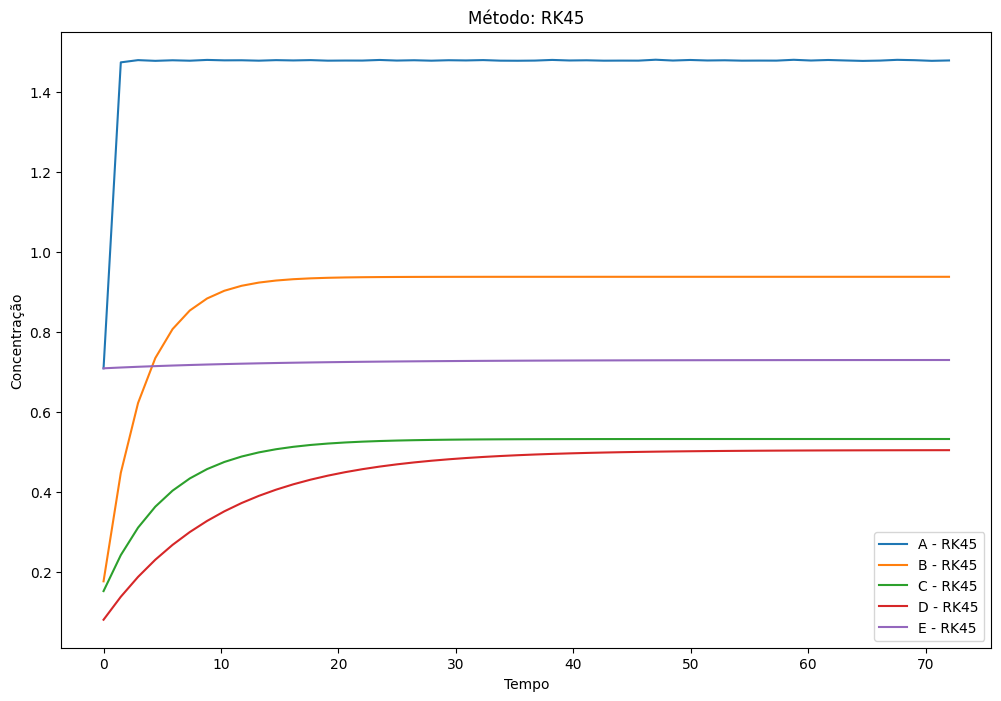

Overflow


In [ ]:
population = toolbox.generate()
Individual.apply_bounds(population)

for gen in range(100):
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)

    toolbox.update(population)
    Individual.apply_bounds(population)

    record = stats.compile(population)
    print(f"Generation {gen}: {record}")

    hof.update(population)
    
    best_ind = Individual.list_to_ind(hof[0])
    print(f"best ind coeffs: {best_ind.coeffs}")
    #best_ind.plot(comparison=False)

    population = toolbox.generate()